In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# What is the derivative?
How the function responds to small changes in the input (the slope)

In [40]:
def f(x):
    return 3*x**2 - 4*x + 5

In [41]:
f(3.0)

20.0

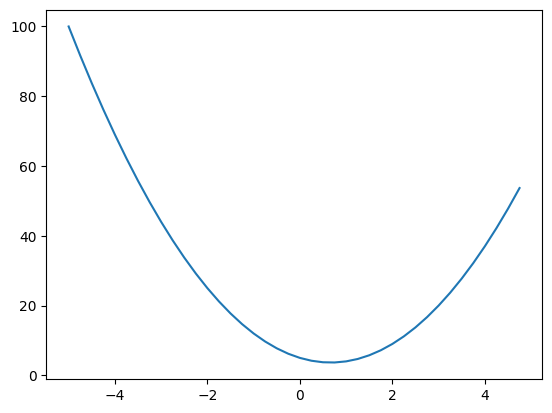

In [42]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [43]:
h = 0.00000000000001 # at same point it gets incorrect because of numeric representation
x = 3.0
(f(x+h) - f(x))/h # how much the function responded – the slope

# f'(x) = 6x - 4 = 6*3 - 4 = 14     it works

14.210854715202004

In [44]:
x = -3.0
(f(x+h) - f(x))/h # negative, because it goes down

-22.026824808563106

In [45]:
x = 2/3
(f(x+h) - f(x))/h 

0.0

In [46]:
# more complex

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c 
a += h
d2 = a*b + c # derivaticve by a
# slope should be b=-3 (the derivative)

print(f"{d1=:.2}\n{d2=}\nslope: {(d2-d1)/h}")

d1=4.0
d2=3.99999999999997
slope: -3.019806626980426


# Lets build micrograd

In [47]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # derivative of loss
        self._backward = lambda: None # backward function does nothing for leaf node
        self._prev = set(_children) # for the graph – how the value was created
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data}, {self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad # we won't accumulate, if the variable is used more than once it doesn't work beacuse it's overwritten
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, power):
        assert isinstance(power, (int, float)), "power must be int or float"
        out = Value(self.data**power, (self, ), f"**{power}")
        def _backward():
            self.grad += power * self.data**(power - 1) * out.grad

        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    

    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        # it can be a complicated function, because we know its derivative
        x = self.data
        t = np.tanh(x)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topological sort to go from the end to the beginning
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) # first the children and me after all of the children
                topo.append(v)
        build_topo(self) # start at o and organize its children

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = "e"

d = e + c; d.label = "d"
f = Value(-2.0, label='f')
L = d * f; L.label = "L"

d._prev

{Value(-6.0, e), Value(10.0, c)}

In [48]:
# visualize the graph of the computation

from graphviz import Digraph

def trace(root):
    # builde a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{n.label}| data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [49]:
# backpropagation manually
L.grad = 1.0 
# dL/dd = f = -2
f.grad = -2.0
d.grad = -2.0

# dd/dc = 1
# dL/dc = dL/dd * dd/dc = -2 * 1 = -2
c.grad = -2.0
e.grad = -2.0

# de/da = b
# dL/da = dL/de * de/da = -2 * -3 = 6
a.grad = 6.0
b.grad = -4.0


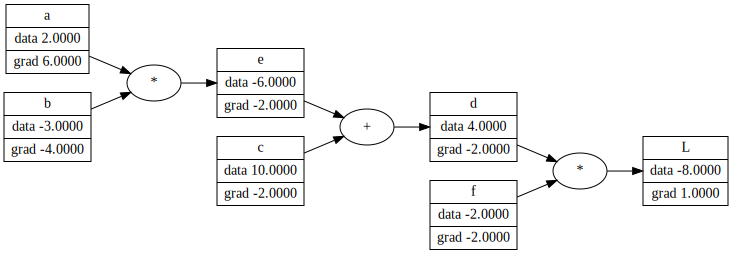

In [50]:
draw_dot(L) # forward pass

In [51]:
a.data += a.grad * 0.01 # for step size in the direction of the gradient
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

# # forward pass
e = a * b
d = e + c
L = d * f 

print(L.data)

-7.509552


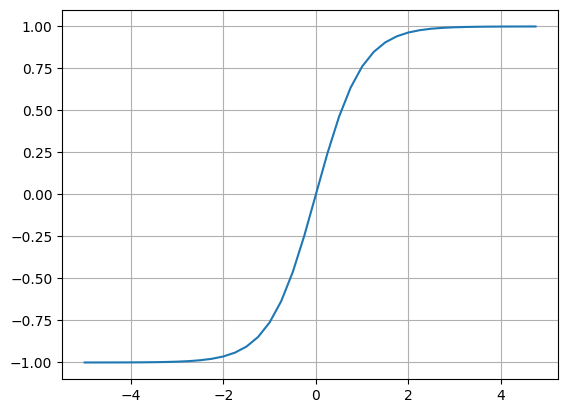

In [52]:
# squashing function example
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid()

## Neuron

In [53]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = n.tanh();
# the level is up to us, we can define the tangent like this and implement more backporpagation functions
e = (2*n).exp()
o = (e - 1)/(e+1)
o.label = "o"


In [54]:
# # manual backprop
# o.grad = 1.0
# # tanh'(x) = 1 - tanh(x)**2 = 1 - o**2
# n.grad = 0.5
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1x2w2.grad


In [55]:
# semi manual backprop
# o.grad = 1.0 
# o._backward() # it should propagate it through tanh and change grad of n
# n._backward()
# b._backward() # it's none, so nothing happens
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [56]:
o.backward()

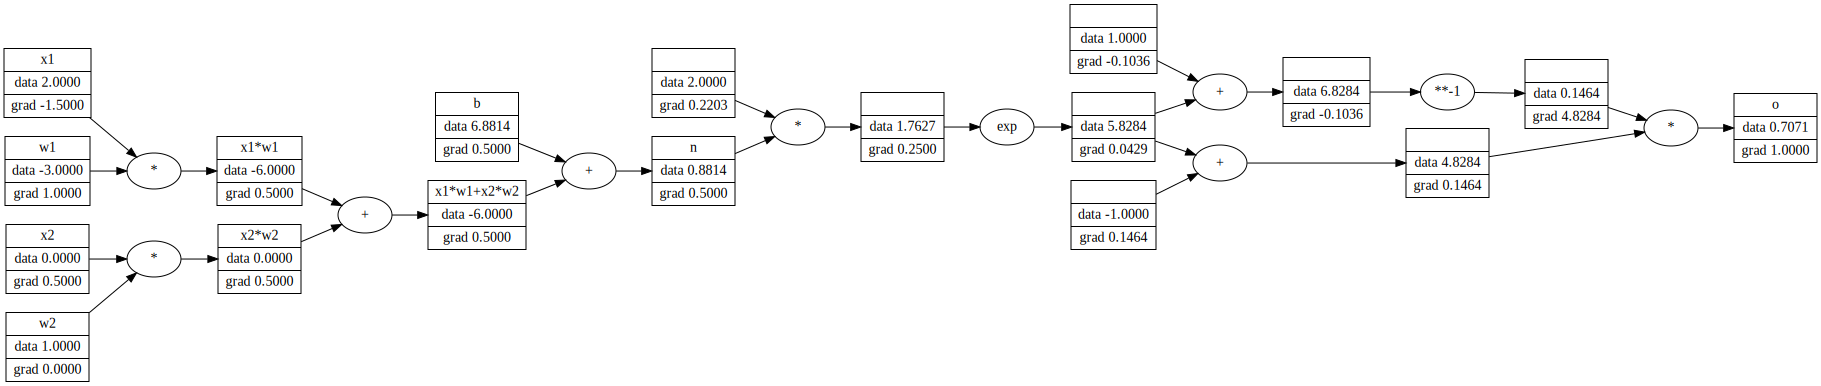

In [57]:
draw_dot(o)
# w1 will increase, w1 will not change

# The same but in pytorch

In [58]:
import torch

# in pytorch everything is a tensor (multidim arrays), not scalar

# python by default uses double (float64), pytorch uses float32
x1 = torch.Tensor([2.0]).double();               x1.requires_grad = True # by defafult they not use gradients for efficiency
x2 = torch.Tensor([0.0]).double();               x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();              w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();               w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b # aritchmethic like in micrograd
o = torch.tanh(n)

print(o.data.item())    # .item() to get one element, not tensor
o.backward()
print("---")
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

# the results are the same as in micrograd

0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


# Make the network components

NNs are math expresions that take data and weights and params. Loss function tries to measure the error of the network. We want to minimize it. Folowing the gradient and changing the weights minimizing the loss is called gradient descent.

In [114]:
import random

class Neuron:
    def __init__(self, nin):
        # nin – number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # forward pass w * x + b
        act =  sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # start from b to be more efficient
        out = act.tanh()
        return out
    
    def parameters(self): # pytorch style
        # return all parameters of the neuron
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Neuron({len(self.w)} in)"
    
    
class Layer():
    def __init__(self, nin, nout):
        # nout – number of neurons (outputs) in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer({len(self.neurons)} * {self.neurons[0]})"
        
    
class MLP():
    def __init__(self, nin, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # previous layer's output is the input for the next layer
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP({self.layers})"
    

In [147]:
x = [2.0, 3.0, -1.0]
# n = Neuron(len(x))
# n = Layer(len(x), 3)
n = MLP(len(x), [4,4,1])
print(n, n(x), len(n.parameters()), sep="\n")
# draw_dot(n(x))

MLP([Layer(4 * Neuron(3 in)), Layer(4 * Neuron(4 in)), Layer(1 * Neuron(4 in))])
Value(-0.7016784745326528, )
41


In [148]:
# binary classifier
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # 4 examples, 3 features

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [160]:
# gradient decent – forward pass, backward pass, update

for k in range(20):
    # FORWARD PASS
    ypred = [n(x) for x in xs]
    
    # we'd like to push the predictions to the targets
    # we need a loss function – single number that measures the net's performance

    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # MSE
    # we need to minimize the loss

    # BACKWARD PASS
    # we need to zero the gradient, because it's accumulated
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # UPDATE
    # we want to change w and b, but not x towards the direction of the gradient

    for p in n.parameters():
        # 0.05 is the learning rate
        # - because we'd like to decrease the loss. Gradient is pointing to the direction of the increase of the loss
        p.data += -0.05 * p.grad 
    
    print(k, loss.data)


0 0.0038531398786939277
1 0.0038275385247933764
2 0.0038022301240951406
3 0.003777210042446765
4 0.003752473739405534
5 0.0037280167659104945
6 0.003703834762023407
7 0.0036799234547365512
8 0.0036562786558447615
9 0.0036328962598796877
10 0.003609772242104208
11 0.0035869026565647456
12 0.0035642836341997506
13 0.0035419113810023846
14 0.003519782176235535
15 0.0034978923706974864
16 0.0034762383850366414
17 0.003454816708113497
18 0.003433623895408546
19 0.0034126565674743575


In [134]:
# print(n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data)
# # gradient is negative, so it negatively affects the loss, we need to move it up a bit

# # we do the backpropagation

# print(n.layers[0].neurons[0].w[0].data)
# # it's slightly bigger, towards the desired prediction (1)

# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss
# # the loss after forward pass is slightly smaller

In [161]:
ypred # close to the targets

[Value(0.9662592189929593, ),
 Value(-0.9715303555402661, ),
 Value(-0.964209752411802, ),
 Value(0.986481354120286, )]